In [ ]:
!pip install torchsampler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [43]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import optim
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchsampler import ImbalancedDatasetSampler
from collections import OrderedDict

import numpy as np
import os
from tqdm import tqdm
import gc
# plot
import matplotlib.pyplot as plt
import cv2

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [45]:
class dataset(Dataset):
    def __init__(self, root, traintest) -> None:
      super().__init__()
      self.root = root
      self.training_set = []
      if traintest == "train":
        for i, camera in enumerate(os.listdir(root)):
          images = np.load(root + camera)
          images_len = len(images)
          for image in images[:int(images_len*0.7)]:
            information = {
              'image':torch.tensor(image),
              'target':torch.tensor(int(camera.split('.')[0].split('_')[2]))
              }
            self.training_set.append(information)
            
      elif traintest == "test":
        for i, camera in enumerate(os.listdir(root)):
          images = np.load(root + camera)
          images_len = len(images)
          for image in images[int(images_len*0.7):]:
            information = {
              'image':torch.tensor(image),
              'target':torch.tensor(int(camera.split('.')[0].split('_')[2]))
              }
            self.training_set.append(information)
    def __getitem__(self, index):
      return self.training_set[index]
    
    def __len__(self):
      return len(self.training_set)
    
    def get_labels(self):
      return [int(item['target']) for item in self.training_set]


In [46]:
root = '/content/drive/MyDrive/data/'
training_set = dataset(root, 'train')
train_dataloader = DataLoader(training_set, batch_size=4)#, sampler=ImbalancedDatasetSampler(training_set))
test_set = dataset(root, 'test')
test_dataloader = DataLoader(test_set, batch_size=4)

In [47]:
prnudatas = dict(zip(range(35), [None for _ in range(35)]))
prnuroot = '/content/drive/MyDrive/FlatPRNU/'
for i, prnu_name in enumerate(os.listdir(prnuroot)):
  prnu = np.load(prnuroot + prnu_name)
  prnudatas[i] = prnu

In [48]:
class csi_model(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(csi_model, self).__init__()
        """
        N = (w − k + 2p )/s + 1
        """
        self.conv1 = torch.nn.Conv2d(in_channels, 128, kernel_size=(3, 3), padding = 1)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(128, 32 , kernel_size=(1, 1))
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.conv3 = torch.nn.Conv2d(32, 32, kernel_size=(1, 1))
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(32, 128, kernel_size=(1, 1))
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = torch.nn.Conv2d(128, 3, kernel_size=(3, 3), padding = 1)
        self.relu5 = torch.nn.ReLU(3)

        self.conv6 = torch.nn.Conv2d(3, 128 , kernel_size=(3, 3), padding = 1)
        self.bn6 = nn.BatchNorm2d(128)
        self.relu6 = torch.nn.ReLU()

        self.conv7 = torch.nn.Conv2d(128, 32 , kernel_size=(1, 1))
        self.bn7 = nn.BatchNorm2d(32)
        self.relu7 = torch.nn.ReLU()

        self.conv8 = torch.nn.Conv2d(32, 32 , kernel_size=(3, 3), padding = 1)
        self.bn8 = nn.BatchNorm2d(32)
        self.relu8 = torch.nn.ReLU()

        self.conv9 = torch.nn.Conv2d(32, 128 , kernel_size=(1, 1))

        self.conv10 = torch.nn.Conv2d(128, out_channels, kernel_size=(1, 1))
        self.bn10 = nn.BatchNorm2d(out_channels)
        

    def forward(self, x):
        # 0.
        res_x = x    # [4, 3, 256, 256]

        # 1.
        x = self.conv1(x) # [4, 128, 254, 254]
        conv1_x = x
        x = self.bn1(x)
        x = self.relu1(x)

        # 2.
        x = self.conv2(x) # [4, 32, 254, 254]
        x = self.bn2(x)
        x = self.relu2(x)

        #3.
        x = self.conv3(x) # [4, 32, 254, 254]
        x = self.bn3(x)
        x = self.relu3(x)
        
        #4.
        x = self.conv4(x) # [4, 128, 254, 254]
        x = x + conv1_x
        x = self.bn4(x)
        
        #5.
        x = self.conv5(x) # [4, ]
        x = x - res_x
        x = self.relu5(x)

        #6.
        x = self.conv6(x)
        conv6_x = x
        x = self.bn6(x)
        x = self.relu6(x)

        #7.
        x = self.conv7(x)
        x = self.bn7(x)
        x = self.relu7(x)

        #8.
        x = self.conv8(x)
        x = self.bn8(x)
        x = self.relu8(x)

        #9.
        x = self.conv9(x)
        x = x + conv6_x

        #10.
        x = self.conv10(x)
        x = self.bn10(x)

        return x

In [50]:
model = csi_model(3, 3).to(device)

In [51]:
mse_loss = nn.MSELoss()

In [52]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [53]:
def train(model, train_dataloader, optimizer, loss_fn, epoch):
    model.train()
    loss_total = 0
    count = 0
    
    for i, data in enumerate(train_dataloader):
      # traing data
      image = data['image'].type(torch.FloatTensor).to(device)
      image = image.permute(0, 3, 2, 1)
      i_min, i_max = image.min(), image.max()
      image = (image - image.min())/(image.max() - image.min())

      ## Target
      target = data['target']
      truth = torch.tensor([prnudatas[int(item)] for item in target])
      truth = truth.repeat(1, 3, 1, 1)
      truth = (truth - truth.min())/(truth.max() - truth.min())
      truth = truth.to(device)
      
      

      ##
      optimizer.zero_grad()
      output = model(image)
      #print(output)
      #print('output shape :',output.shape)
      # print('truth shape :',truth.shape)
      loss = loss_fn.forward(output, truth)
      # print("loss: ", loss.shape)
      #print(loss)
      loss.backward()

      #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.01) 
      optimizer.step()
      loss_total += loss
      count += 1
      #break


    print(f"Epoch {epoch:3d}  | loss: {loss_total/count:8.3f}")
    return loss_total/count

In [ ]:
EPOCH = 10000
loss = []
count = 1
j = 1
for epoch in tqdm(range(EPOCH)):
  loss.append(train(model, train_dataloader, optimizer, mse_loss, epoch)) 
  count += 1
  #scheduler.step()

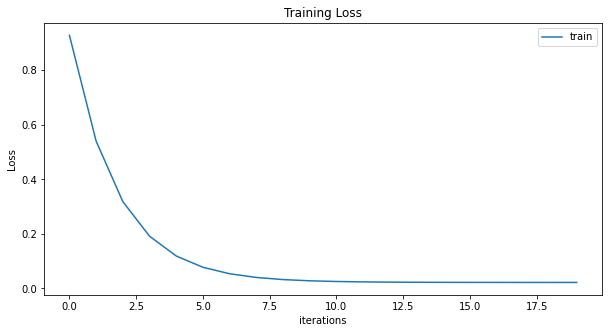

In [56]:
import matplotlib.pyplot as plt
val_losses = []
train_losses = []
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot([item.cpu().detach().numpy() for item in loss], label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [57]:
def test(model, test_dataloader):
  model.eval()
  loss_total = 0
  count = 0
  
  for i, data in enumerate(test_dataloader):
    image = data['image'].type(torch.FloatTensor).to(device)
    image = image.permute(0, 3, 2, 1)
    i_min, i_max = image.min(), image.max()
    image = (image - image.min())/(image.max() - image.min())
    target = data['target']
    truth = torch.tensor([prnudatas[int(item)] for item in target])
    truth = truth.to(device)
    truth = truth.repeat(1, 3, 1, 1)
    t_min, t_max = truth.min(), truth.max()
    truth = (truth - t_min)/(t_max - t_min)

    output = model(image)
    loss = mse_loss.forward(output, truth)
    loss_total += loss.item()
    count += 1


  print(f"loss: {loss_total/count:8.3f}")
  return loss_total/count
        

In [ ]:
test(model, test_dataloader)

In [59]:
model.eval()
outputs = {0:[], 1:[], 2:[], 3:[], 4:[], 6:[], 11:[], 16:[], 20:[], 23:[]}
for i, data in enumerate(test_dataloader):
  image = data['image'].type(torch.FloatTensor).to(device)
  image = image.permute(0, 3, 2, 1)
  image = torch.abs(image)
  i_min, i_max = image.min(), image.max()
  image = (image - image.min())/(image.max() - image.min())
  target = data['target']

  truth = torch.tensor([prnudatas[int(item)] for item in target])
  t_min, t_max = truth.min(), truth.max()

  output = model(image)
  output = output * (t_max - t_min) + t_min
  for j, item in enumerate(target):
    outputs[int(item)].append(output[j].cpu().detach().numpy())

In [81]:
for i in outputs.keys():
  np.save('/content/drive/MyDrive/new_prnu_2/res_noise_'+str(i)+'.npy', np.array(outputs[i]))